#Base

In [3]:
#importar bibliotecas
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
tf.__version__

'2.18.0'

In [4]:
from tensorflow.python.client import device_lib

# Verifica se o TensorFlow está vendo a GPU
print("GPU disponível:", tf.config.list_physical_devices('GPU'))


GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Carregamento e preparação da base de dados

In [5]:
#tf.keras.datasets.fashion_mnist.load_data() dataset com as roupas
(dataset, data_class), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

(60000, 28, 28)

(60000,)

8


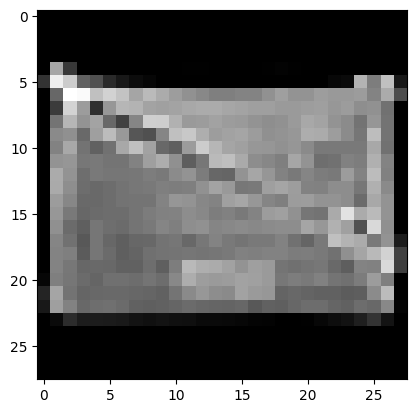

In [6]:
display(dataset.shape, data_class.shape)
num = np.random.randint(0,60000)
print(data_class[num])
plt.imshow(dataset[num], cmap = 'gray');

Caso a normalização seja para -1 a 1, usamos a tanh, como será de 0 a 1, vamos usar a sigmoide para ativação nesse caso

In [7]:
# 1 canal para gray scale, seria 3 para RGB
# reshape para o formato esperado pelas CNN e float32 pois é o trabalhado com tensorflow e keras
dataset = dataset.reshape(dataset.shape[0], 28, 28, 1).astype('float32')
display(dataset.shape)
display(dataset[0].min(), dataset[0].max())
dataset = (dataset - 127.5)/127.5 #normalizando para os pixels variarem de -1 a 1 ao inves de 0 a 255
display(dataset[0].min(), dataset[0].max())

(60000, 28, 28, 1)

np.float32(0.0)

np.float32(255.0)

np.float32(-1.0)

np.float32(1.0)

In [8]:
#Dividir a base de dados em batches de 256 imagens cada
#Mini batch gradient descent
#Vamos criar 234 batches de 256 imagens
'''Os pesos atualizam a cada batch, além de subir menos dados por vez para a
memória, tornando o processo mais rápido e eficiente'''
buffer_size = 60000
batch_size = 256

In [9]:
#precisamos converter o numpy array para o formato do tensorflow
display(type(dataset))
# enviamos os dados do treinamento e fazemos o shuffle para evitar que a
# IA aprenda as imagens na ordem em que estão
dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(buffer_size).batch(batch_size)
display(type(dataset))
display(dataset)

numpy.ndarray

tensorflow.python.data.ops.batch_op._BatchDataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

#Construindo o Gerador

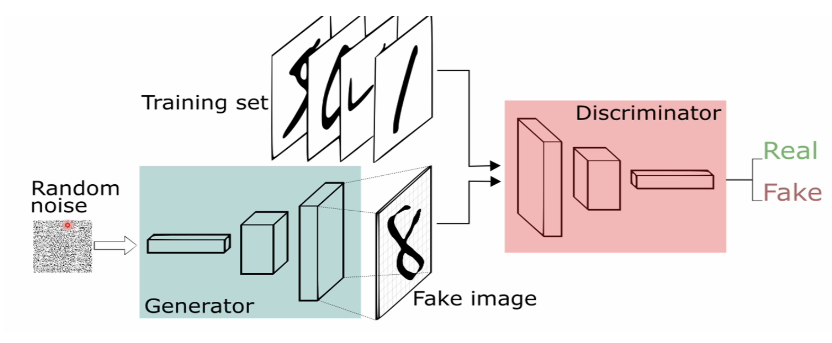

In [10]:
def gerador():
    network = tf.keras.Sequential()

    #recebemos um vetor e convertemos em matriz
    #input_shape espera uma tupla, por isso a "," depois do 100
    network.add(layers.Dense(units = 7*7*256,
                             use_bias = False,
                             input_shape=(100,)))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    network.add(layers.Reshape((7, 7, 256)))

    # 7x7x128
    #strides=(2,2) dobra a altura e a largura na deconvolução
    network.add(layers.Conv2DTranspose(filters=128,
                                       kernel_size=(5,5),
                                       padding='same',
                                       use_bias=False,
                                       strides=(2,2)))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    #14x14x64
    network.add(layers.Conv2DTranspose(filters=64,
                                       kernel_size=(5,5),
                                       padding='same',
                                       use_bias=False,
                                       strides=(2,2)))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())

    #28x28x1
    network.add(layers.Conv2DTranspose(filters=1,
                                       kernel_size=(5,5),
                                       padding='same',
                                       use_bias=False,
                                       #strides=(2,2), ficaria 56x56
                                       activation='tanh'))
    network.summary()
    return network



In [11]:
meu_gerador = gerador()  #se for a primeira vez, somente essa linha
meu_gerador.load_weights('/content/gerador.weights.h5') # se for continuar o treino

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [12]:
#from google.colab import drive
#drive.mount('/content/drive')

In [13]:
#olhar o tipo de entrada da rede
# 100 -> 12544 -> 7x7x128 -> 14x14x64 -> 28x28x1
meu_gerador.inputs

[<KerasTensor shape=(None, 100), dtype=float32, sparse=False, name=keras_tensor>]

In [14]:
ruido_input = tf.random.normal([1,100]) # cria um vetor com 100 valores
ruido_input

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.8228447 , -0.00468368,  1.9548948 ,  0.844727  ,  1.3808154 ,
         1.1563232 ,  0.5630547 ,  0.37626195, -1.7067701 , -0.2671149 ,
        -1.2747636 ,  0.3255595 , -0.8799974 , -0.6630745 , -1.5610287 ,
         0.456013  ,  2.8917232 , -0.8607678 ,  1.4253336 ,  1.6198589 ,
        -0.07317904, -1.5371426 , -0.6644921 ,  1.0747145 ,  0.01562478,
        -1.488816  , -1.4290776 ,  0.47098884,  0.65426177,  0.4893165 ,
         0.16380468,  0.8256573 , -0.60852486, -1.0549462 ,  0.0411342 ,
         0.47946477,  1.7673625 , -1.0011706 , -1.1679069 ,  0.11861265,
         0.22487469, -0.8594076 , -1.0532377 , -0.7210172 ,  0.3561726 ,
         1.63549   ,  0.28044662, -0.96503735,  0.23615663, -0.31223243,
        -0.6503964 , -0.8751427 , -0.6579255 , -0.51076835,  1.9012349 ,
         1.0758758 ,  0.19525012,  0.79868376, -1.6183429 , -0.08653275,
         1.254928  , -0.4723039 , -0.11134971,  0.37839556,  0.8501178 ,
 

TensorShape([1, 28, 28, 1])

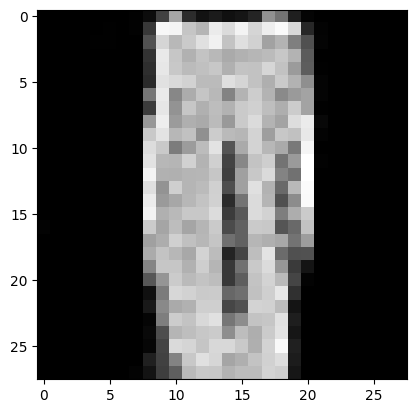

In [15]:
imagem_fake = meu_gerador(ruido_input)
display(imagem_fake.shape)
plt.imshow(imagem_fake[0, :, :, 0], cmap = 'gray')

#Contruindo o Discriminador

In [16]:
def discriminador():
    network = tf.keras.Sequential()

    #14x14x64  recebe 28x28x1
    #Conv2D para convolução
    #Conv2DTranspose para deconvolução
    #strides=(2,2) divide por 2 a altura e largura na convolução
    network.add(layers.Conv2D(filters=64,
                              kernel_size=(5,5),
                              strides=(2,2),
                              padding='same',
                              input_shape=[28,28,1]))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    #7x7x128
    network.add(layers.Conv2D(filters=128,
                              kernel_size=(5,5),
                              strides=(2,2),
                              padding='same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    network.add(layers.Flatten())
    network.add(layers.Dense(1)) # todo vetor ligado ao neurônio de saída

    network.summary()
    return network


In [17]:
meu_discriminador = discriminador() # se for a primeira vez, somente essa linha
meu_discriminador.load_weights('/content/discriminador.weights.h5') #  para continuar o treino

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#formato do input
meu_discriminador.inputs

[<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=keras_tensor_67>]

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.21769166]], dtype=float32)>

<tf.Tensor: shape=(), dtype=float32, numpy=0.49848687648773193>

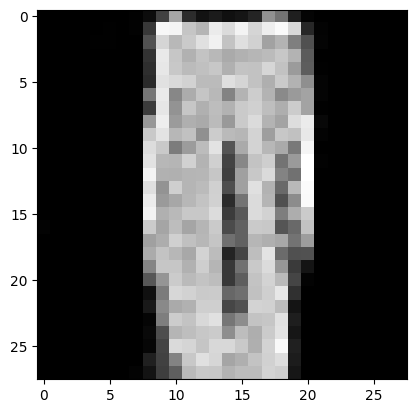

In [19]:
#vamos ver o discriminador tentando ver se a imagem é real ou fake
display(meu_discriminador(imagem_fake))
#o numpy=array([-0.00605243]) é a saída antes da ativação
display(tf.sigmoid(-0.00605243)) #ativação
plt.imshow(imagem_fake[0,:, :, 0], cmap = 'gray');

#o resultado mostra 49,8% de chance de ser real
#não ajuda muito, vamos criar os parametros de erro e treinar
#para depois comparar a melhora dos resultados

#Cálculo do Erro

Logits https://deepai.org/machine-learning-glossary-and-terms/logit Este método quantifica quão bem o discriminador é capaz de distinguir imagens reais de falsificações.

In [20]:
#passamos que o formato da resposta será logits
#logit é a saída da network antes de aplicar uma ativação como sigmoid
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)
display(cross_entropy)

<LossFunctionWrapper(<function binary_crossentropy at 0x7f6ed7085440>, kwargs={'from_logits': True, 'label_smoothing': 0.0, 'axis': -1})>

In [21]:
#pelo discriminador:
#as imagens reais são comparadas com uma matriz de valor 1
#as imagens fakes são comparadas com uma matriz de valor 0

#pelo gerador: se compara as imagens fakes com a matriz de valor 1
#pois quer se aproximar do real

display(tf.ones_like(1))
display(tf.zeros_like(1))


<tf.Tensor: shape=(), dtype=int32, numpy=1>

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [22]:
def discriminador_loss(imagem_real_logit, imagem_fake_logit):
    imagem_real_loss = cross_entropy(tf.ones_like(imagem_real_logit),imagem_real_logit)
    imagem_fake_loss = cross_entropy(tf.zeros_like(imagem_fake_logit),imagem_fake_logit)
    return imagem_real_loss + imagem_fake_loss

In [23]:
def gerador_loss(imagem_fake_logit):
    return cross_entropy(tf.ones_like(imagem_fake_logit), imagem_fake_logit)

In [24]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

#Treinamento da GAN e Visualização dos Resultados

In [25]:
epochs = 250 #quantidade de vezes que vai passar pelo dataset
noise_size = 100 #quantidade de numeros aleatorios enviados para o gerador
quantidade_imagens = 100


A função roda como uma função Python comum: interpretada, linha por linha, mais lenta. Com o @tf.function, o TensorFlow compila a função para um grafo computacional estático, que aumenta a performance usando GPUs e TPUs. Compilar esse loop uma vez e reutilizar o grafo é muito mais eficiente. Acelera forward pass, backward pass e o cálculo de gradientes.

In [26]:
@tf.function #transforma em uma função compilada e otimizada pelo TF
def treinamento(imagens):
    # 256 imagens por batch, 256 vetores de ruido com 100 numeros
    noise = tf.random.normal([batch_size, noise_size])

    #gradiente indica se o peso deve subir ou diminuir
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        imagens_geradas = meu_gerador(noise, training = True)

        #deve tender a 1
        imagem_real_logit = meu_discriminador(imagens, training = True)
        #deve tender a 0
        imagem_fake_logit = meu_discriminador(imagens_geradas, training = True)

        #calcula a loss
        gerador_losses = gerador_loss(imagem_fake_logit)
        discriminador_losses = discriminador_loss(imagem_real_logit, imagem_fake_logit)

    #calcula os gradientes

    #atualiza os pesos
    gradientes_gerador = gen_tape.gradient(gerador_losses, meu_gerador.trainable_variables)
    gradientes_discriminador = disc_tape.gradient(discriminador_losses, meu_discriminador.trainable_variables)

    gerador_optimizer.apply_gradients(zip(gradientes_gerador, meu_gerador.trainable_variables))
    discriminador_optimizer.apply_gradients(zip(gradientes_discriminador, meu_discriminador.trainable_variables))

In [27]:
noises = tf.random.normal([quantidade_imagens, noise_size])
noises.shape #16 vetores de 100 valores aleatórios

TensorShape([100, 100])

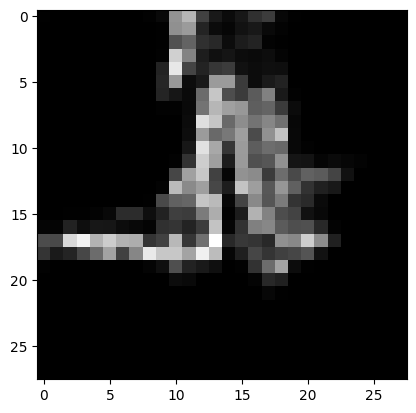

In [28]:
#passando o noise para o gerador e vendo se cria imagem.
#cria 100 imagens, mas pegamos apenas a imagem da posição 0 para mostrar
imagem_teste = meu_gerador(noises)
plt.imshow(imagem_teste[0], cmap='gray')

In [31]:
def treina_gan(dataset, epocas, noises):
    for epoch in range(epochs):
        for imagem_batch in dataset:
            treinamento(imagem_batch) #256 imagens do dataset por vez

        print('época --> ', epoch + 1)

        #depois to treinamento percorrer cada batch vamos gerar uma imagem
        #os pesos atualizam a cada batch (por isso é melhor usar batch ao inves do dataset todo de uma vez)
        preview_imagens = meu_gerador(noises, training = False)
        fig = plt.figure(figsize=(7.5,7.5))

        for i in range(10):
            plt.subplot(3,5,i+1)
            plt.imshow(preview_imagens[i, :, :, 0]*127.5 + 127.5, cmap = 'gray')
            plt.axis('off')
        plt.show()

época -->  1


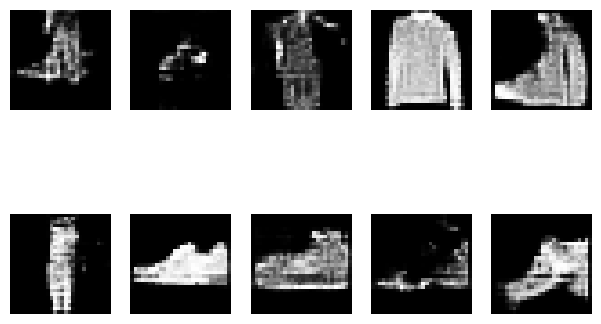

época -->  2


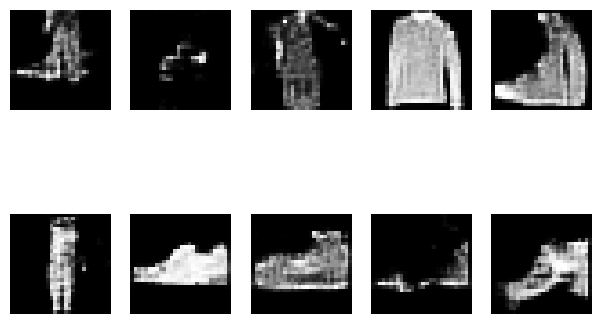

época -->  3


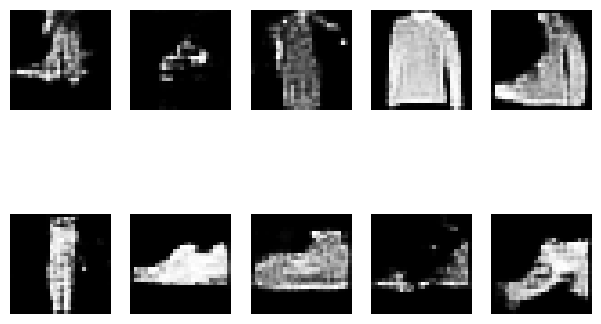

época -->  4


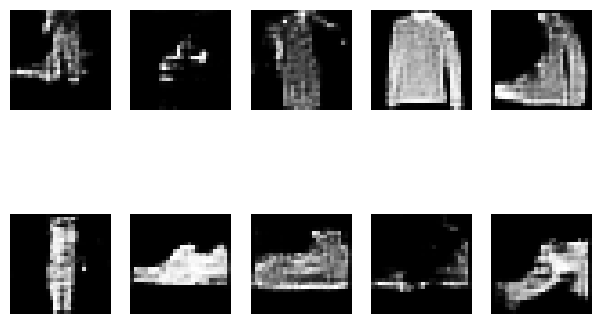

época -->  5


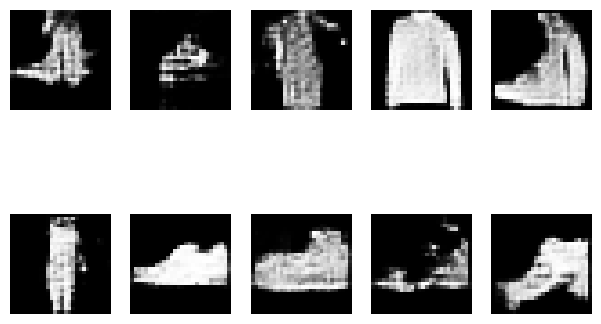

época -->  6


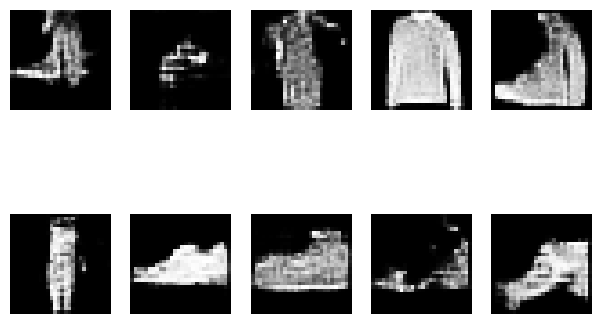

época -->  7


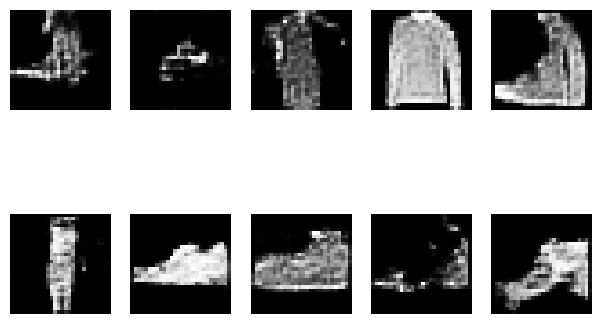

época -->  8


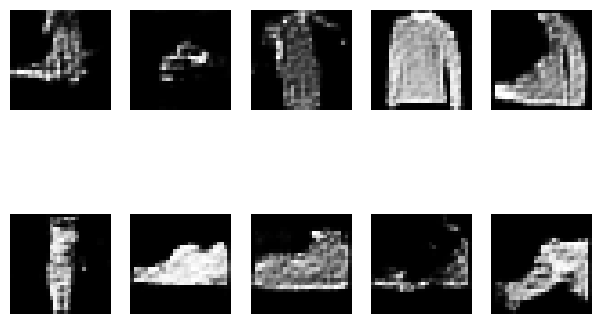

época -->  9


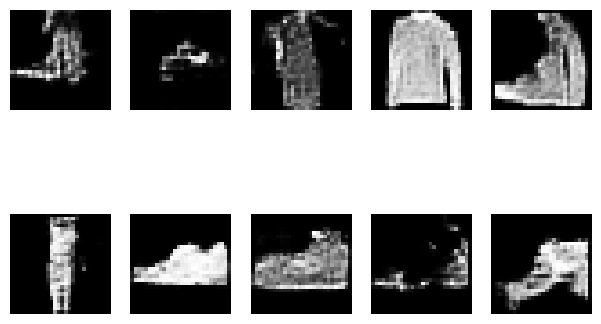

época -->  10


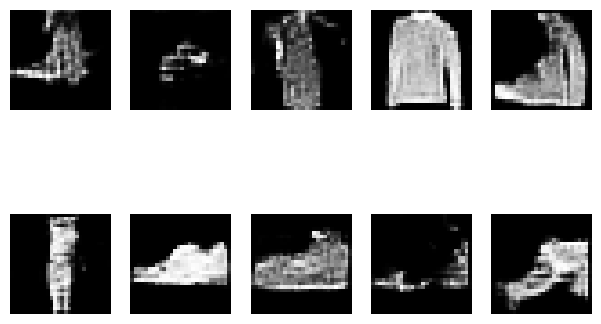

época -->  11


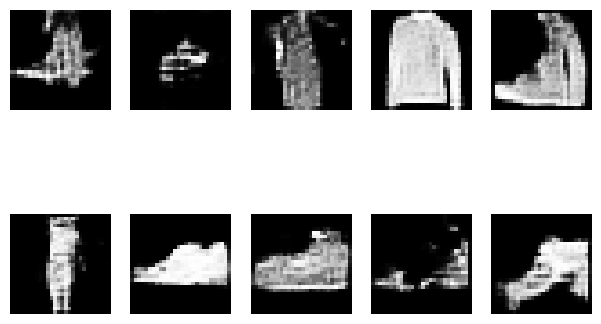

época -->  12


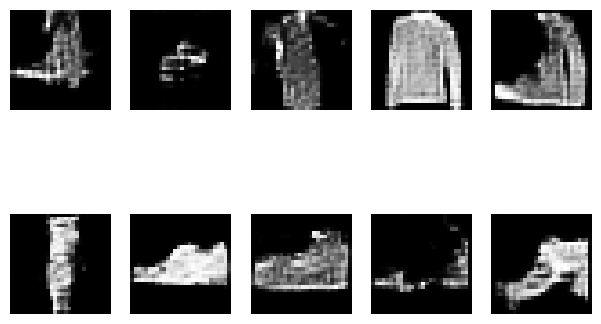

época -->  13


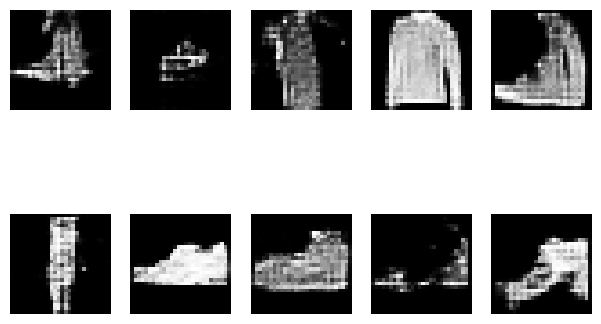

época -->  14


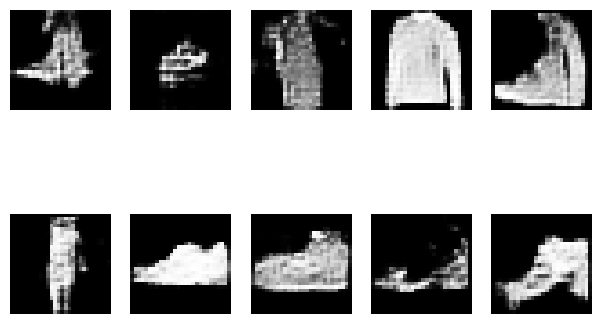

época -->  15


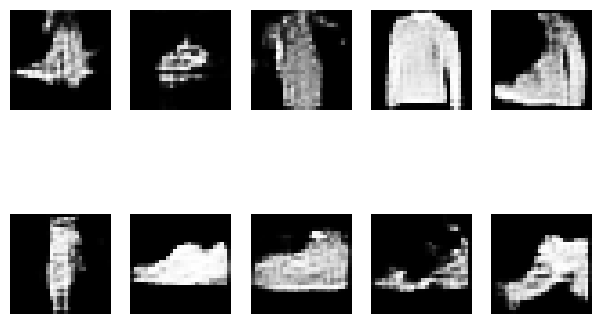

época -->  16


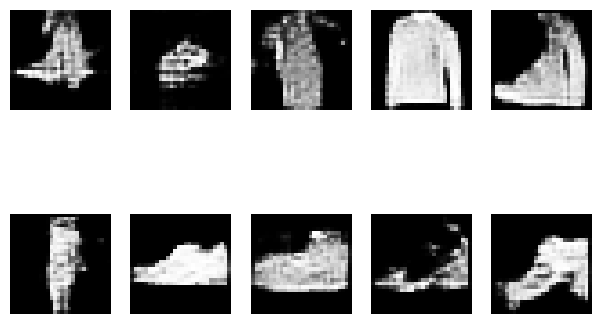

época -->  17


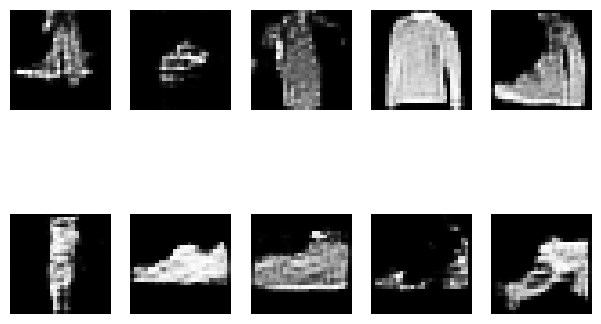

época -->  18


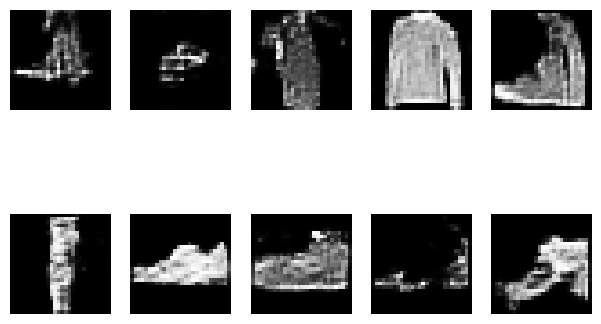

época -->  19


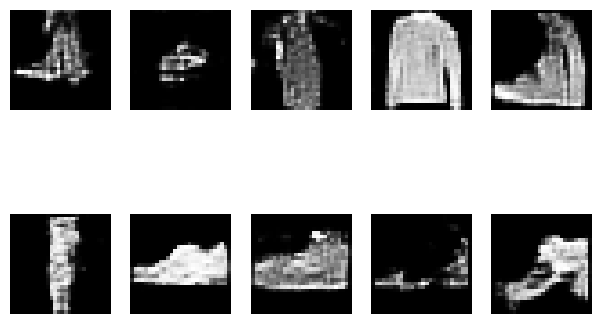

época -->  20


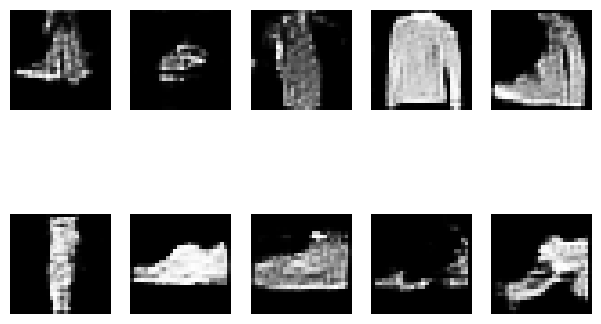

época -->  21


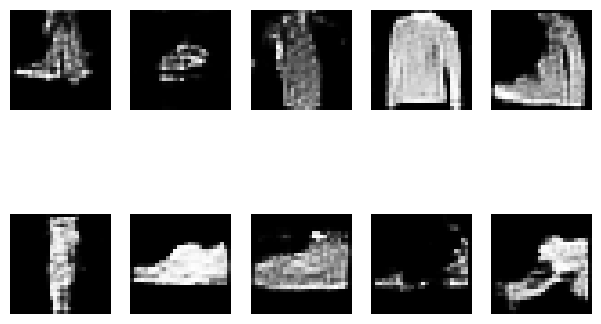

época -->  22


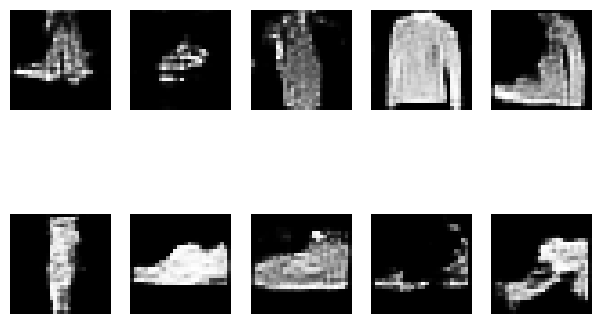

época -->  23


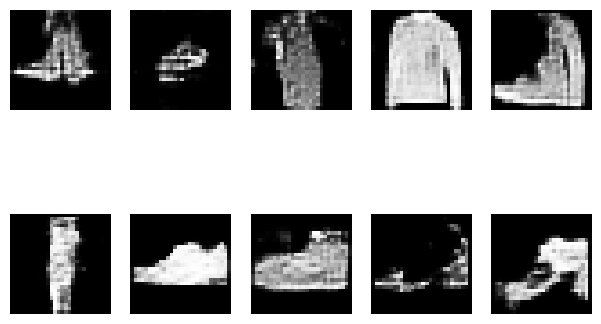

época -->  24


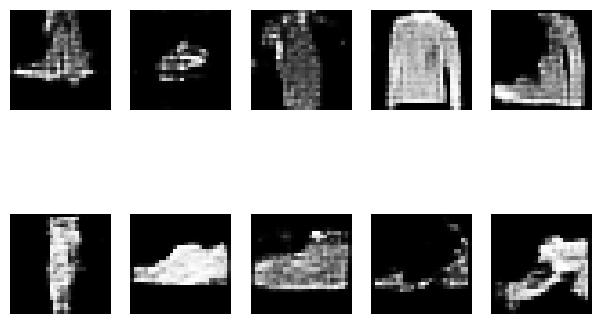

época -->  25


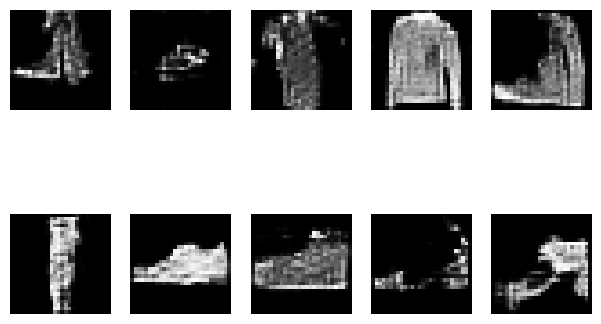

época -->  26


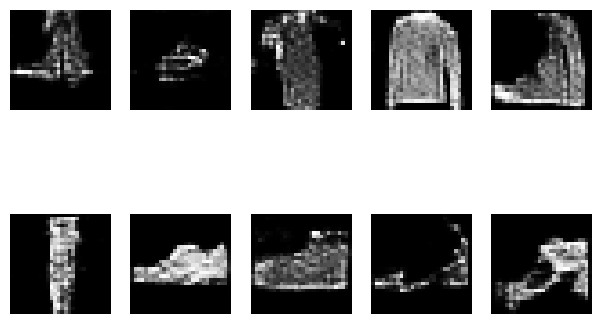

época -->  27


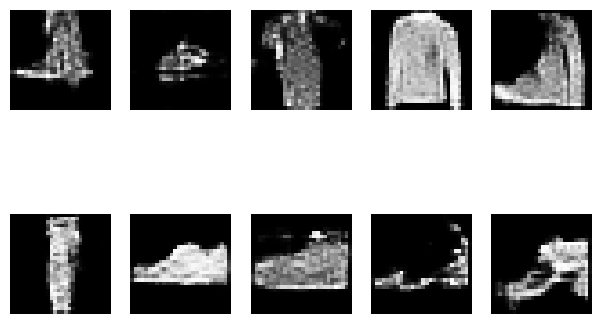

época -->  28


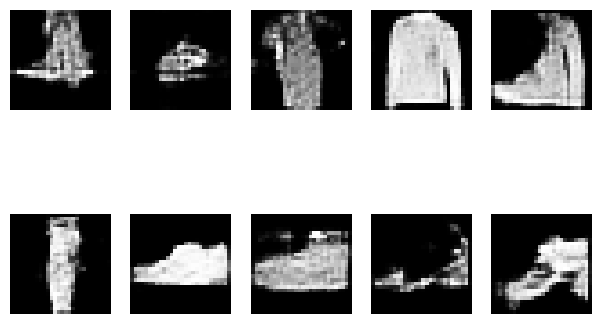

época -->  29


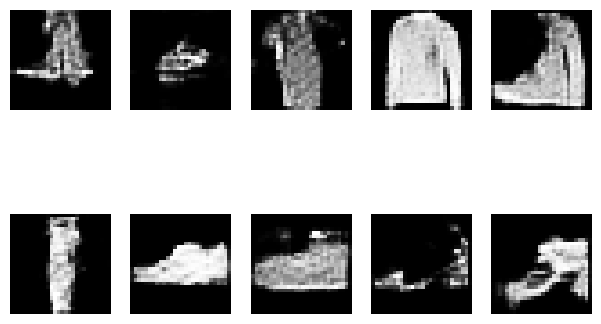

época -->  30


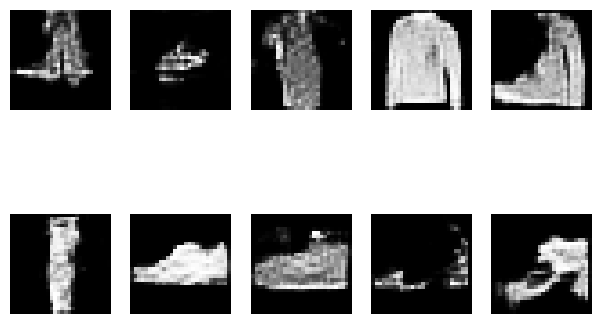

época -->  31


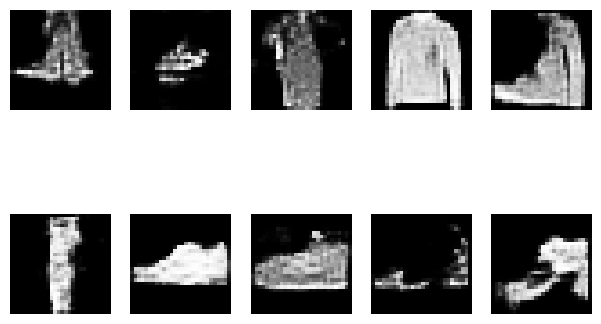

época -->  32


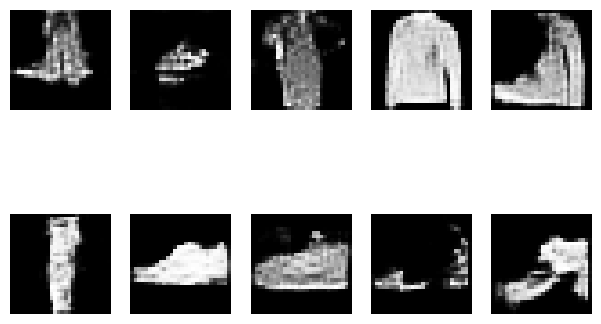

época -->  33


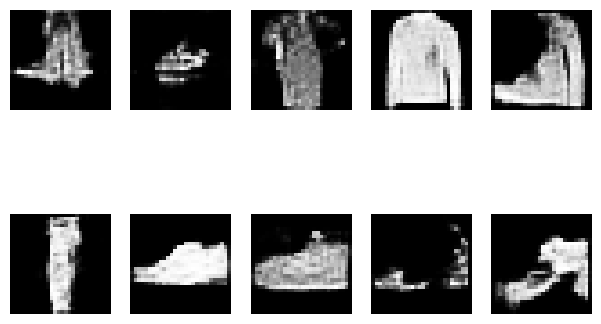

época -->  34


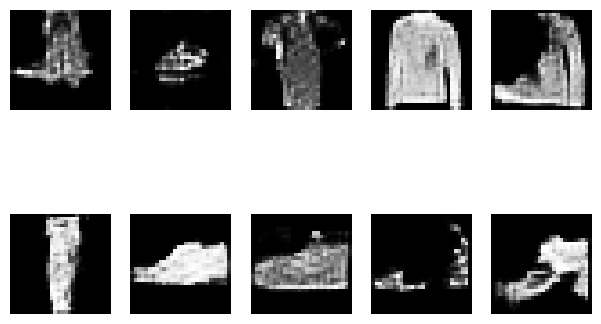

época -->  35


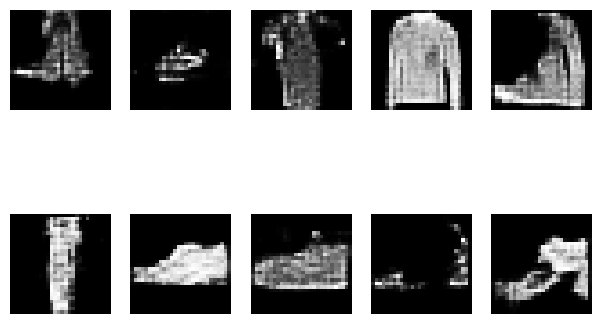

época -->  36


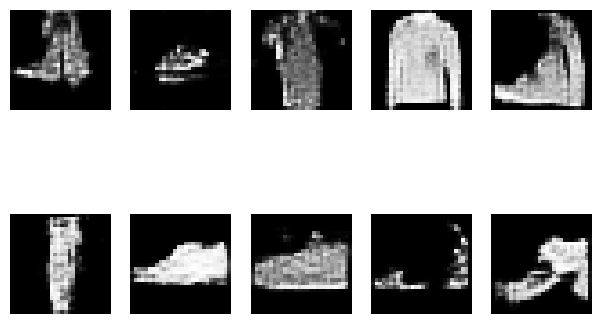

época -->  37


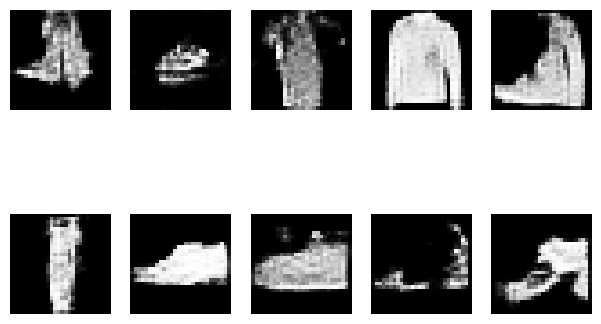

época -->  38


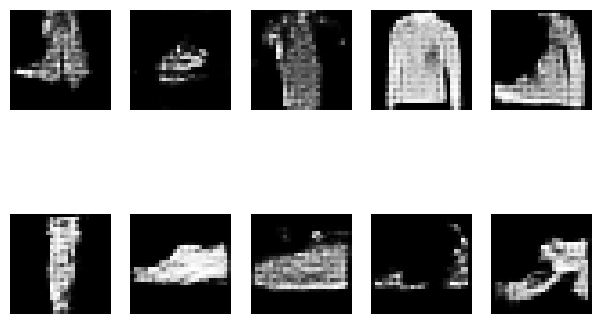

época -->  39


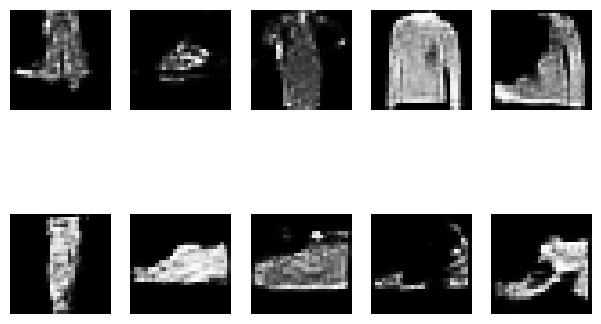

época -->  40


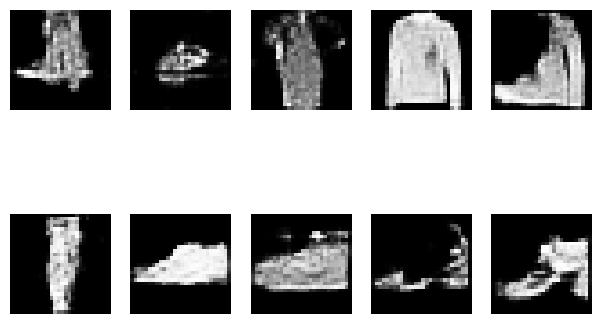

época -->  41


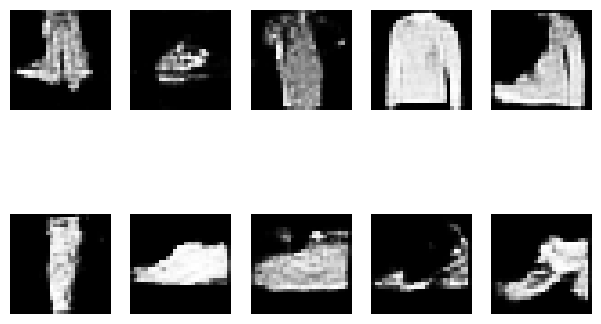

época -->  42


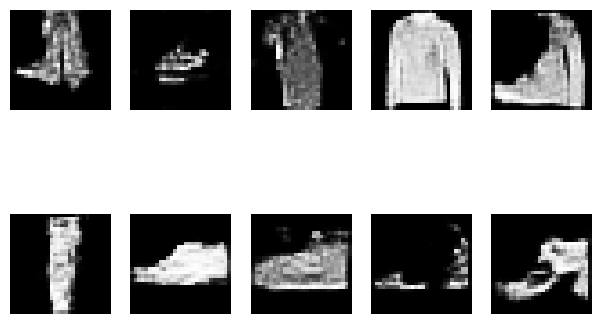

época -->  43


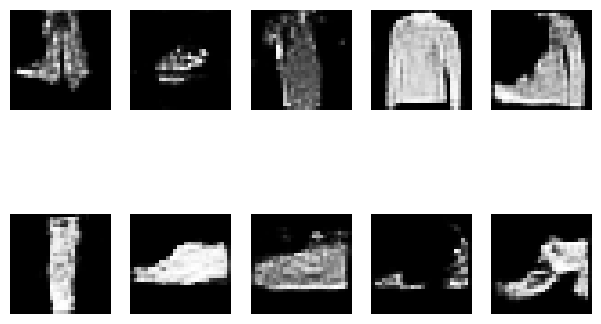

época -->  44


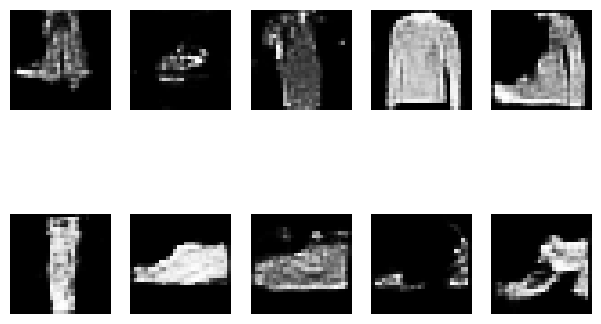

época -->  45


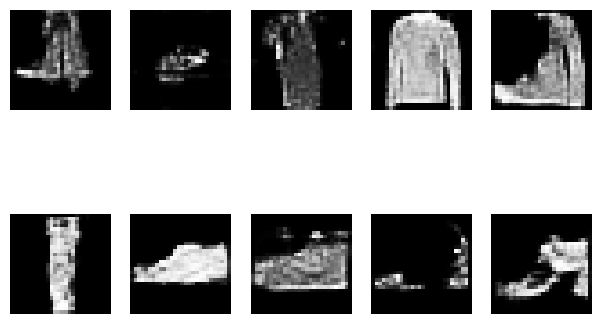

época -->  46


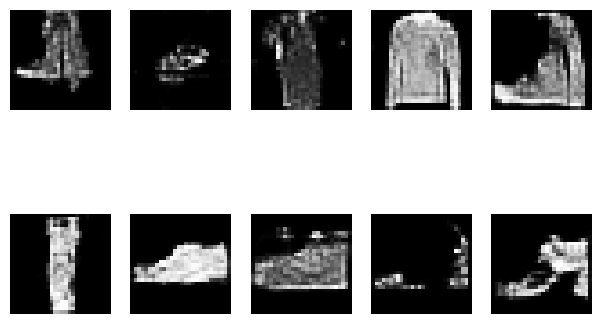

época -->  47


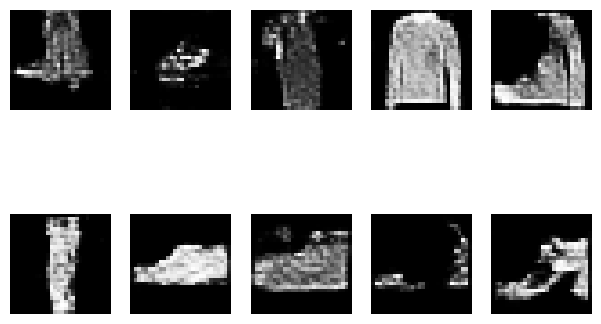

época -->  48


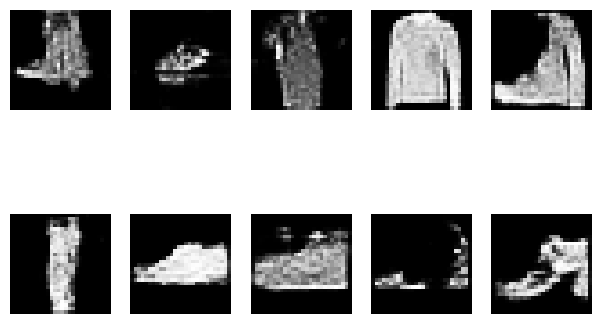

época -->  49


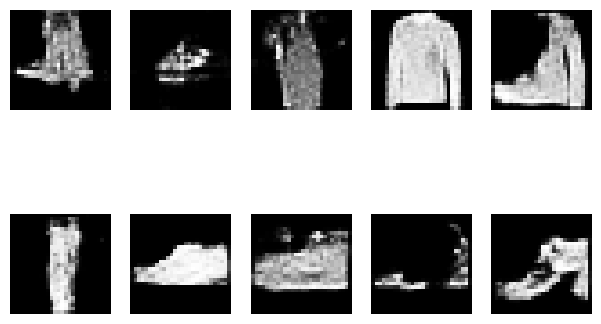

época -->  50


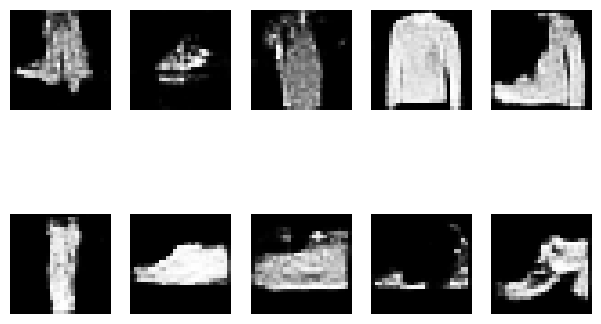

época -->  51


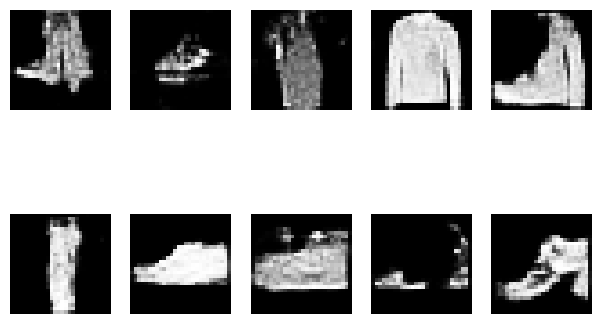

época -->  52


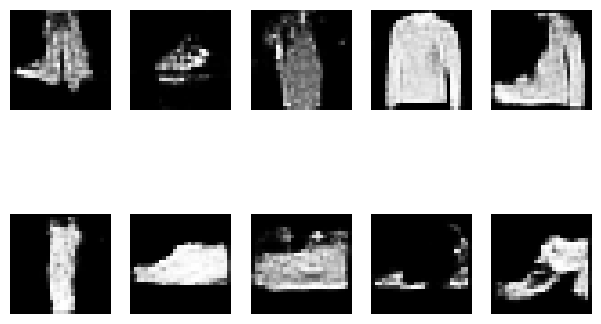

época -->  53


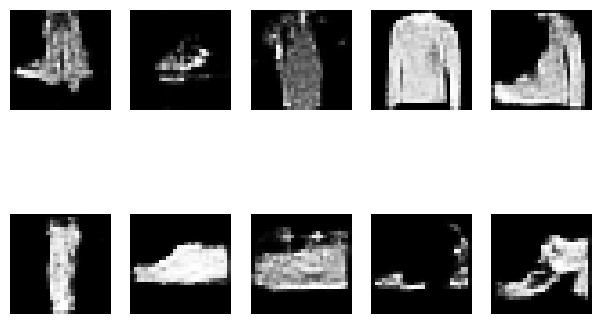

época -->  54


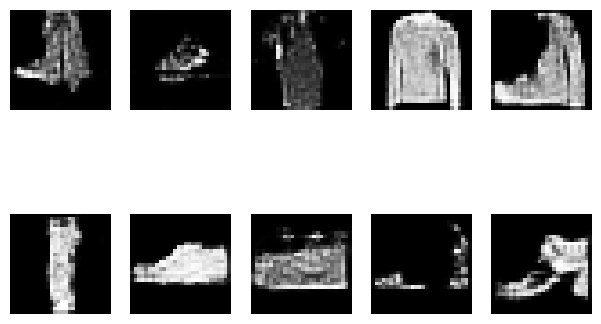

época -->  55


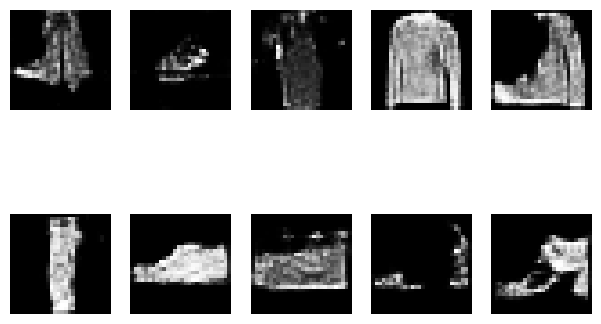

época -->  56


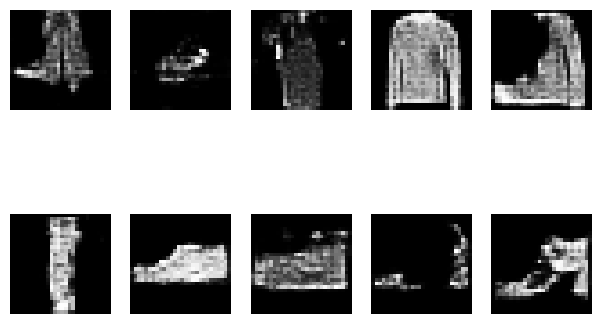

época -->  57


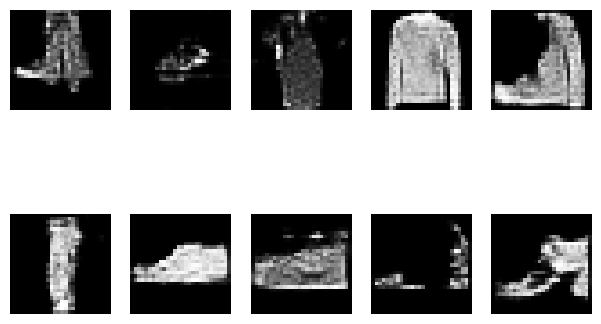

época -->  58


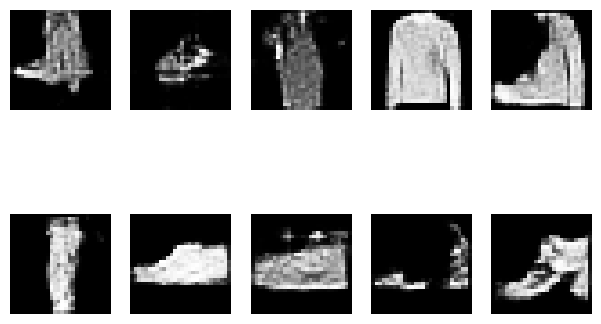

época -->  59


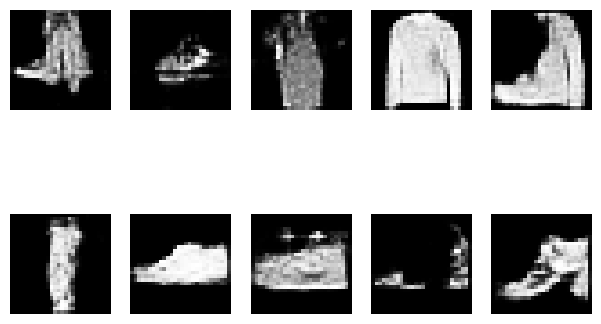

época -->  60


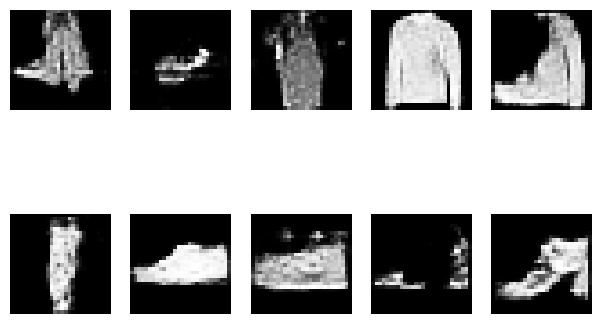

época -->  61


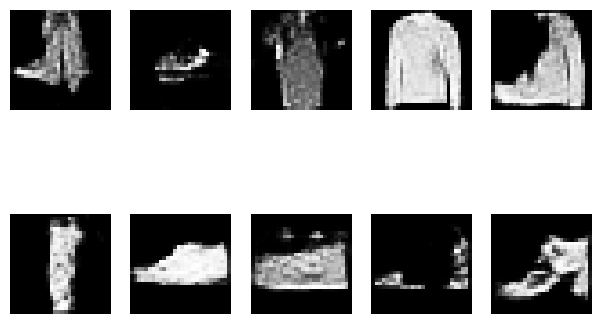

época -->  62


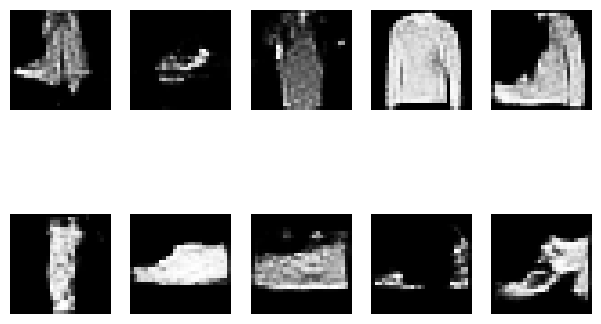

época -->  63


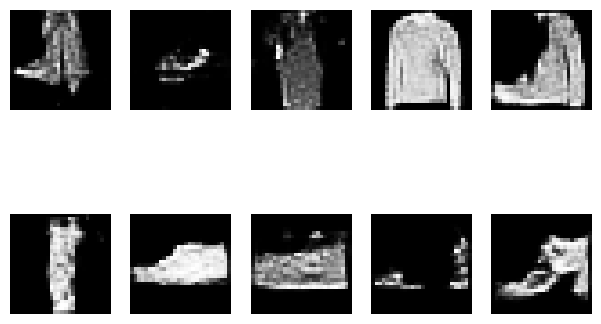

época -->  64


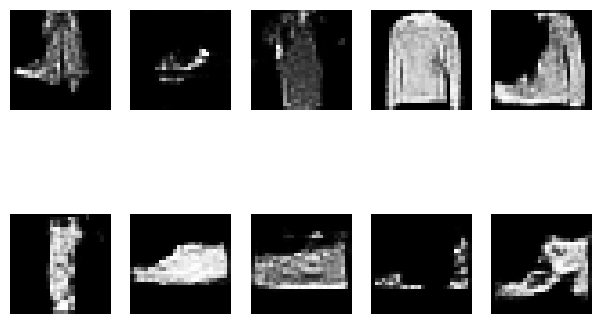

época -->  65


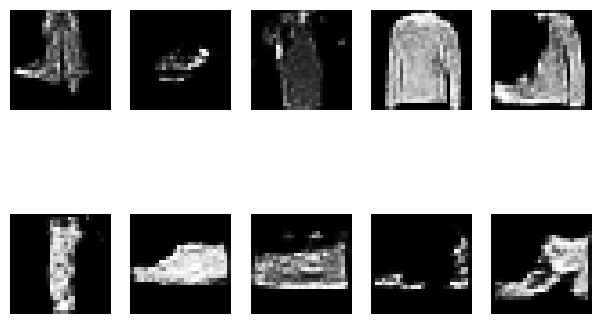

época -->  66


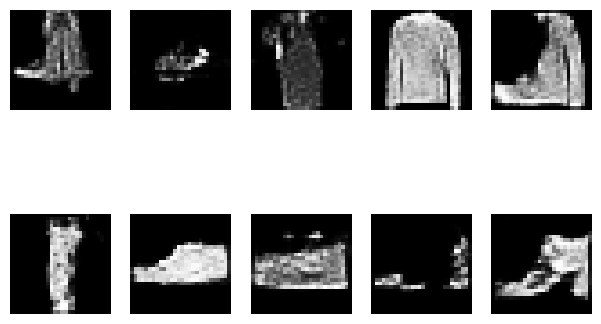

época -->  67


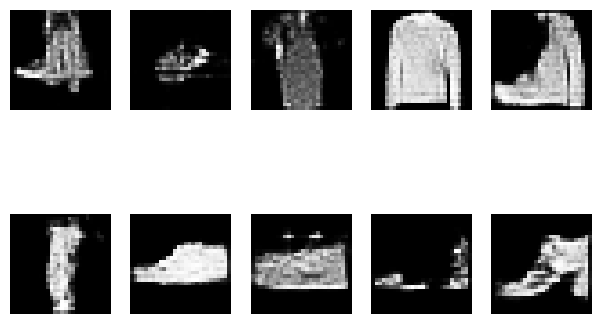

época -->  68


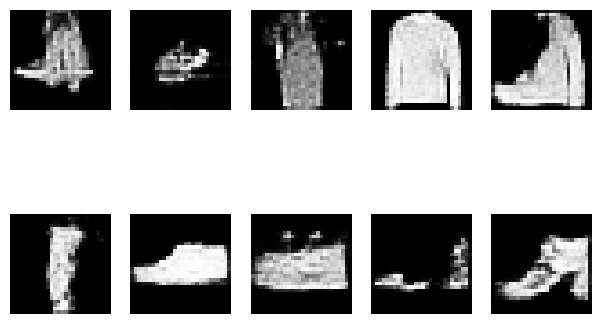

época -->  69


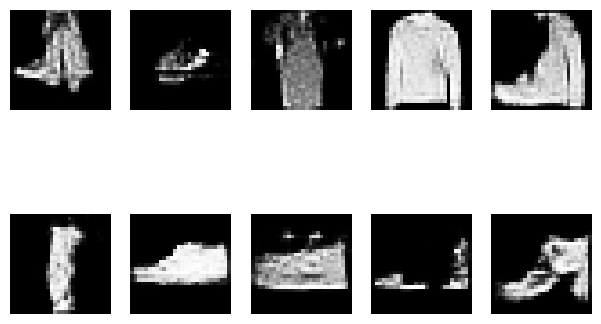

época -->  70


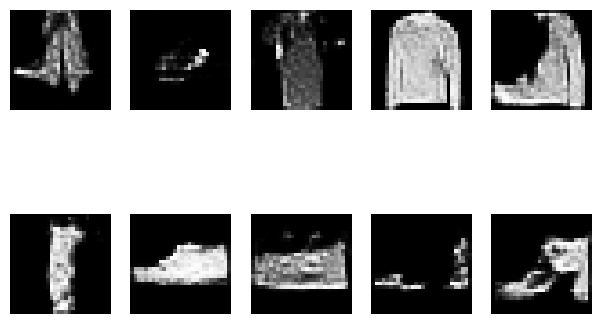

época -->  71


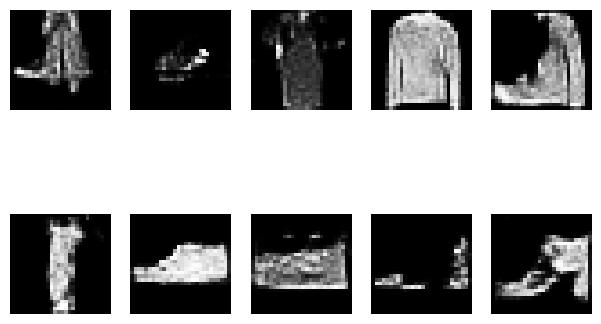

época -->  72


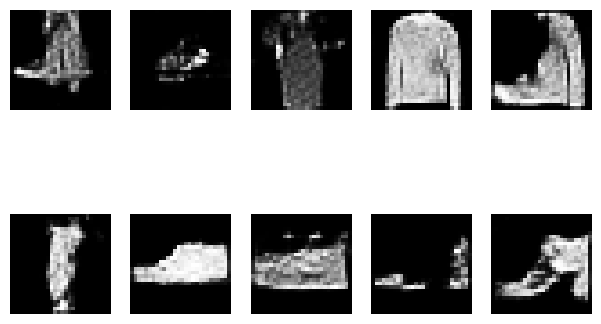

época -->  73


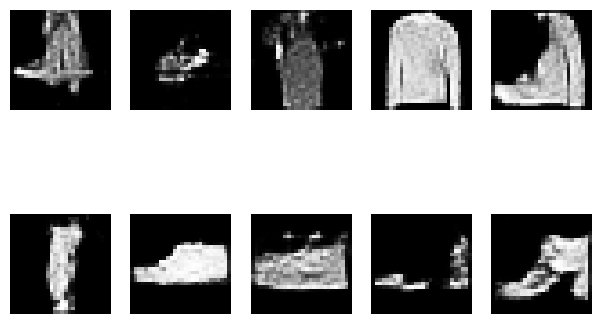

época -->  74


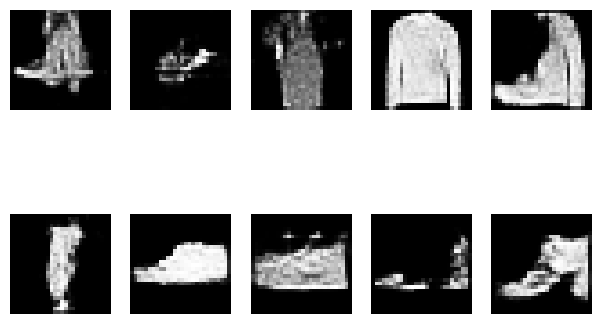

época -->  75


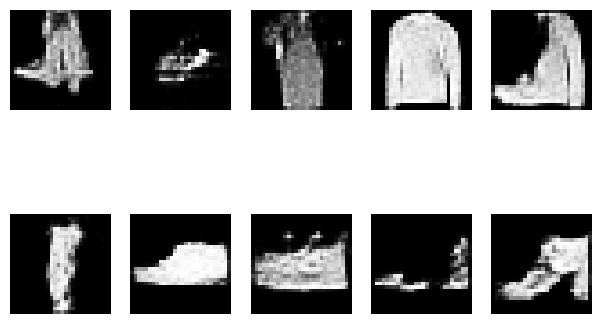

época -->  76


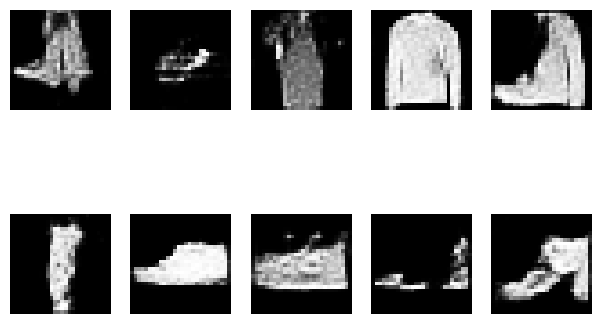

época -->  77


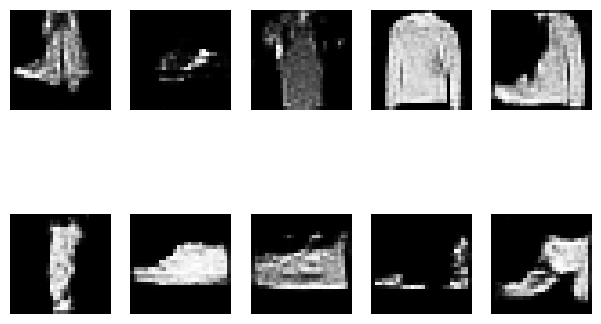

época -->  78


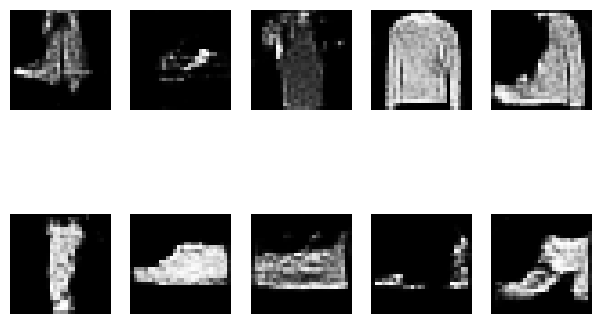

época -->  79


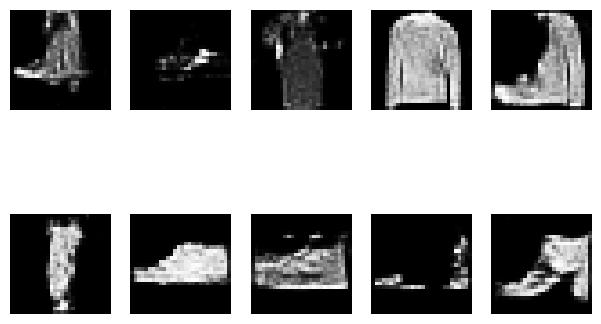

época -->  80


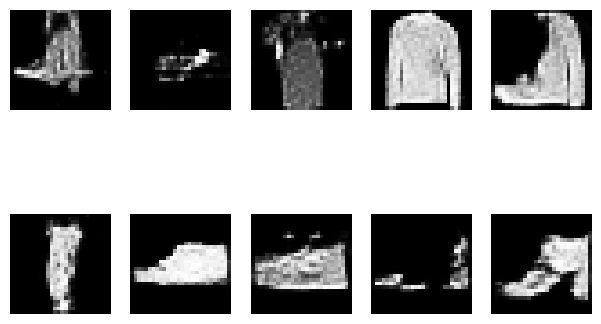

época -->  81


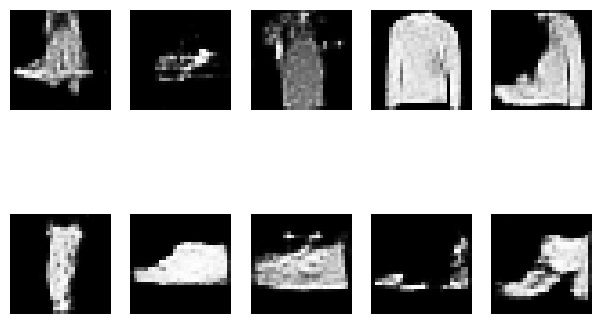

época -->  82


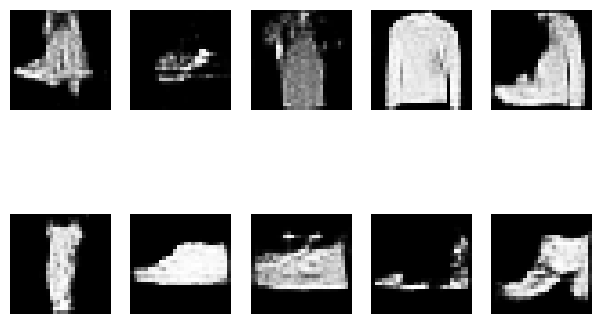

época -->  83


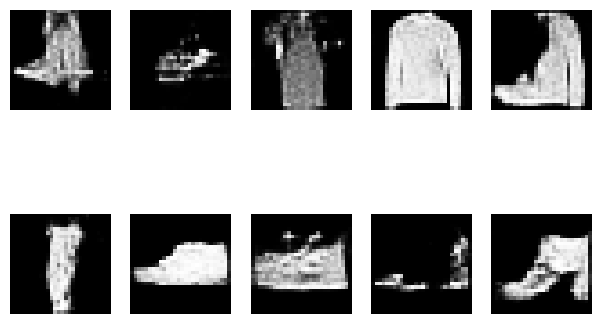

época -->  84


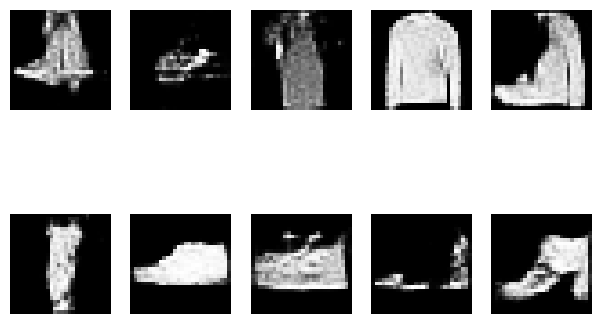

época -->  85


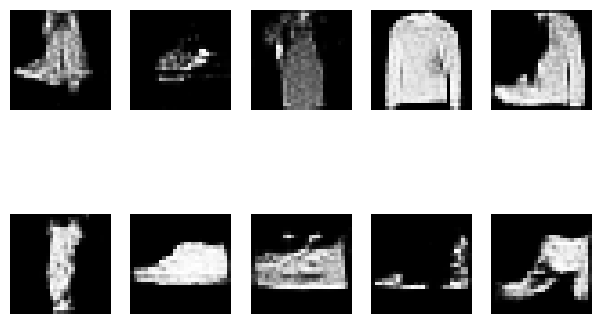

época -->  86


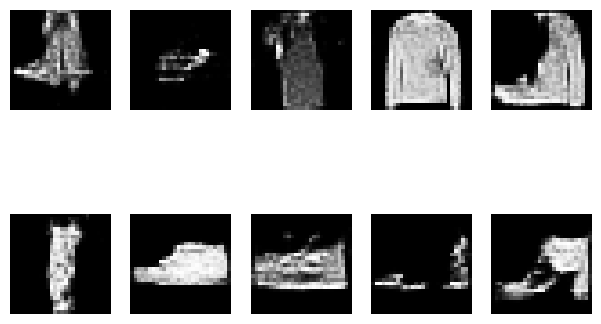

época -->  87


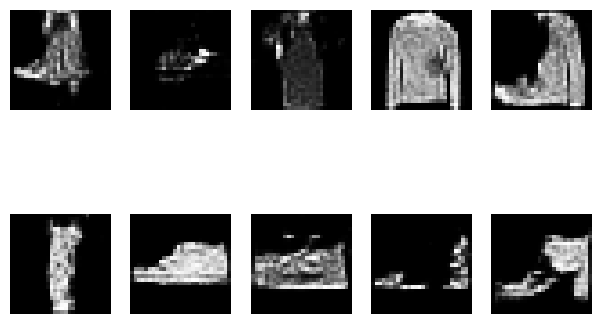

época -->  88


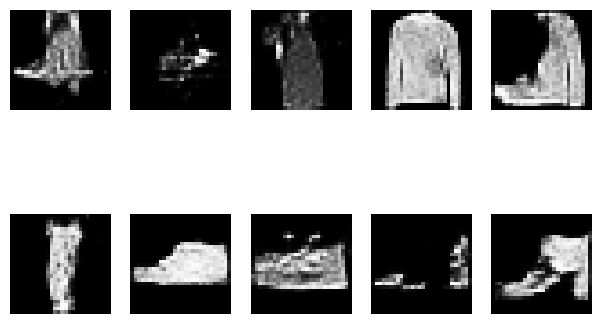

época -->  89


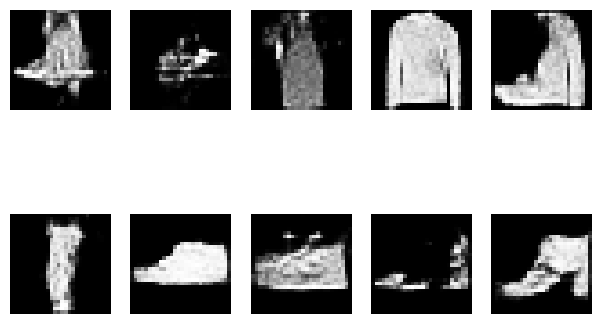

época -->  90


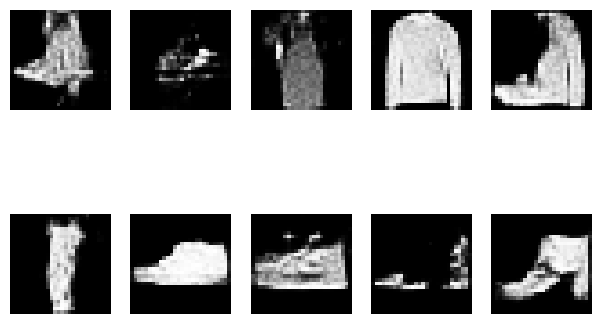

época -->  91


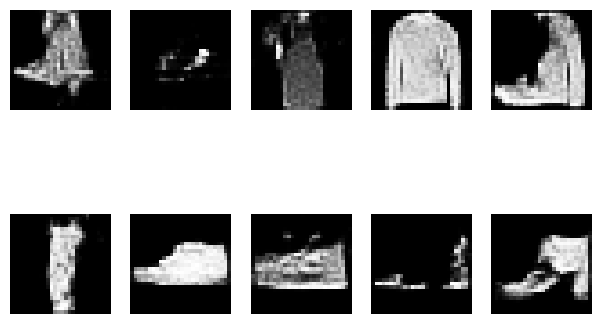

época -->  92


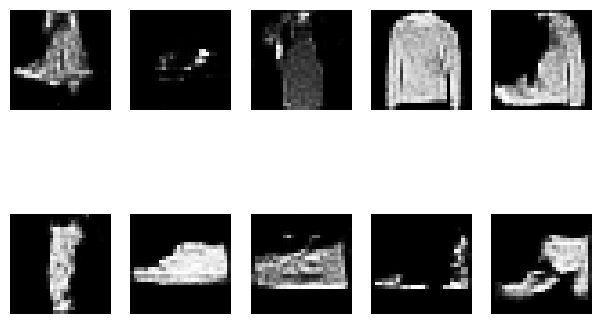

época -->  93


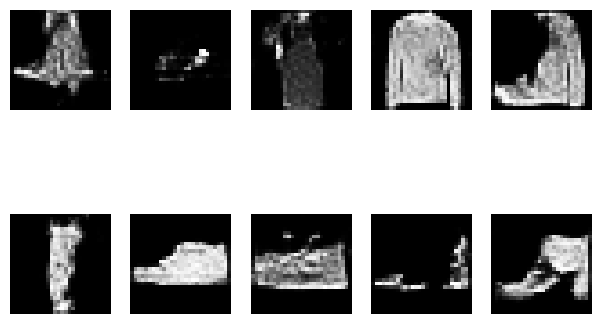

época -->  94


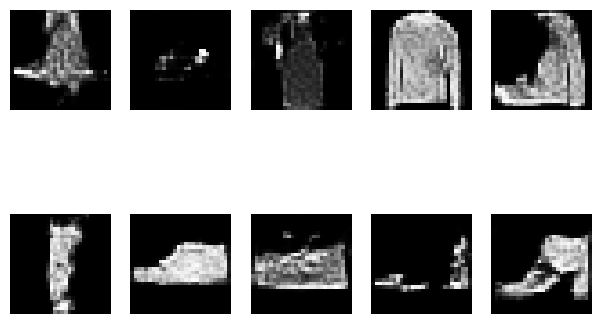

época -->  95


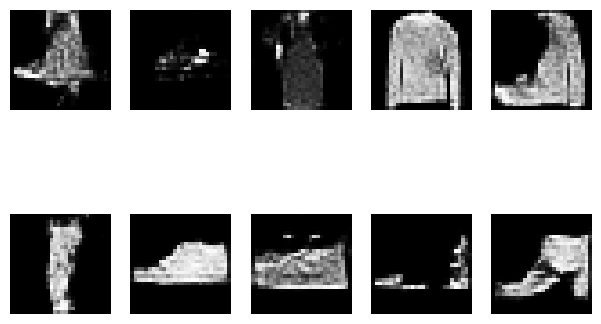

época -->  96


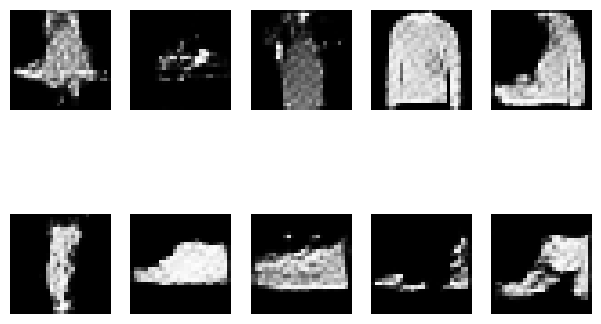

época -->  97


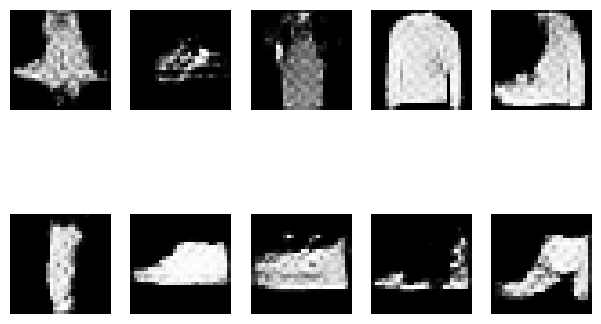

época -->  98


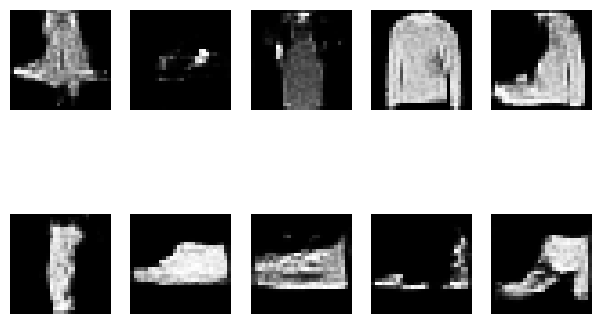

época -->  99


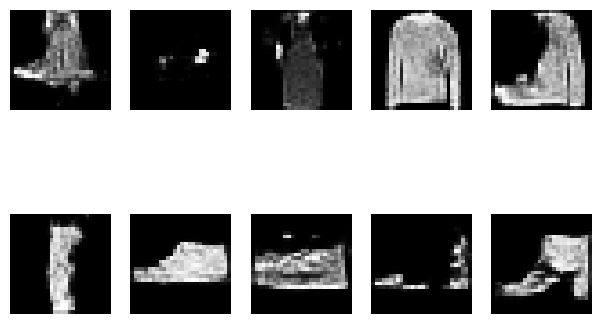

época -->  100


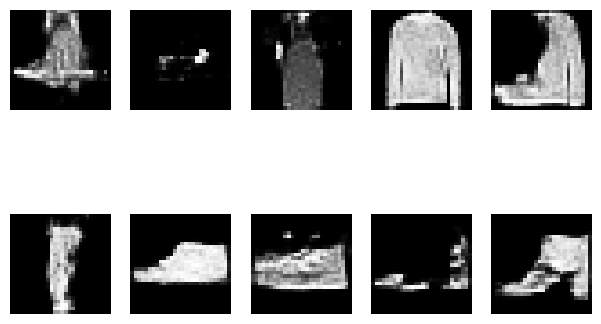

época -->  101


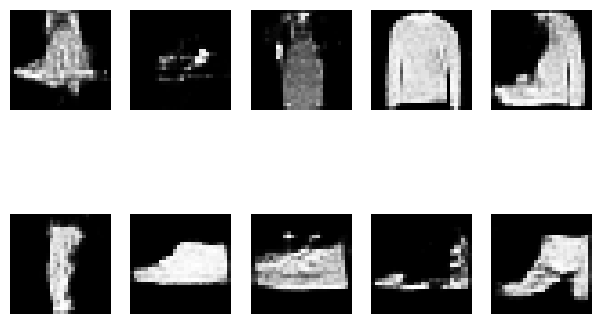

época -->  102


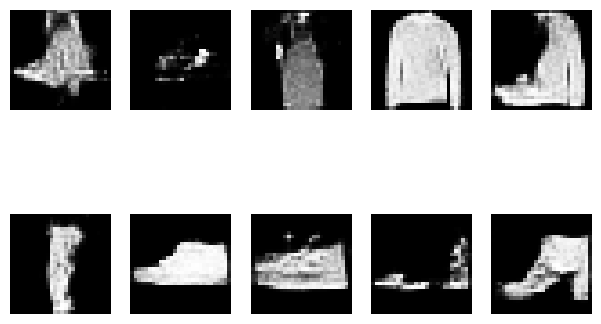

época -->  103


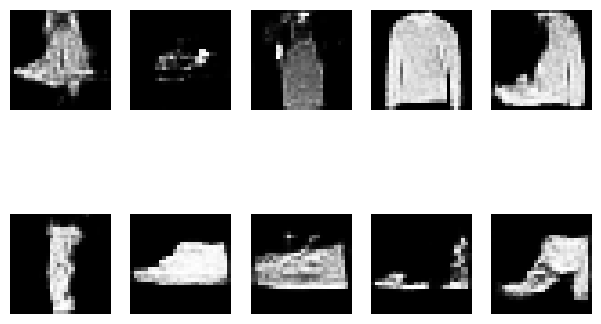

época -->  104


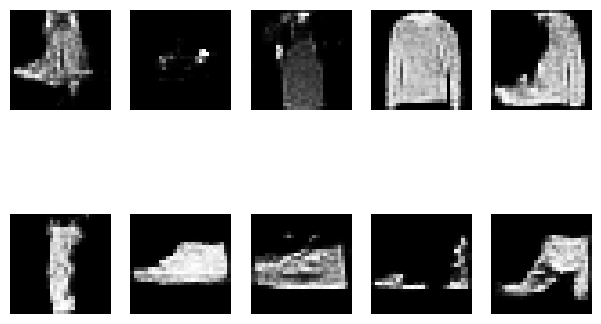

época -->  105


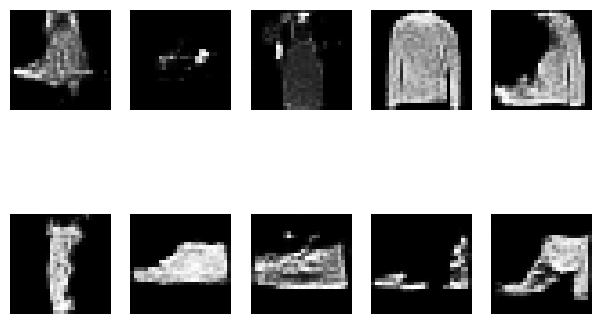

época -->  106


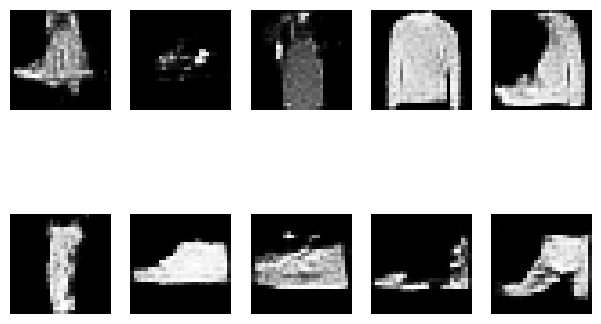

época -->  107


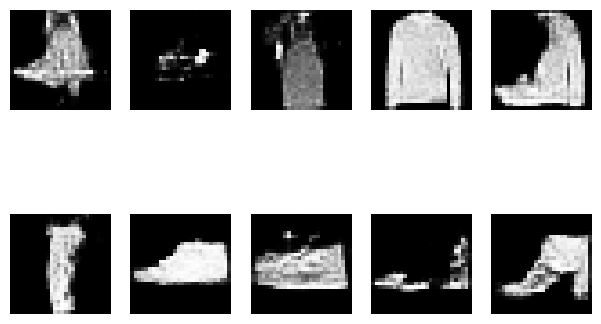

época -->  108


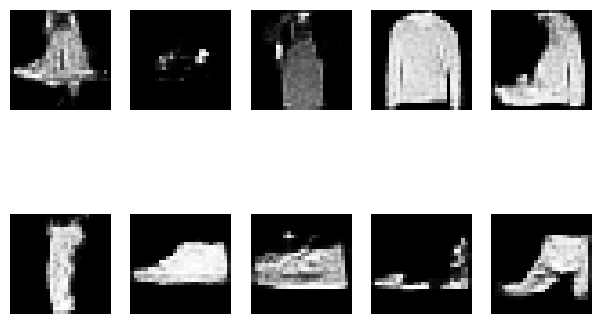

época -->  109


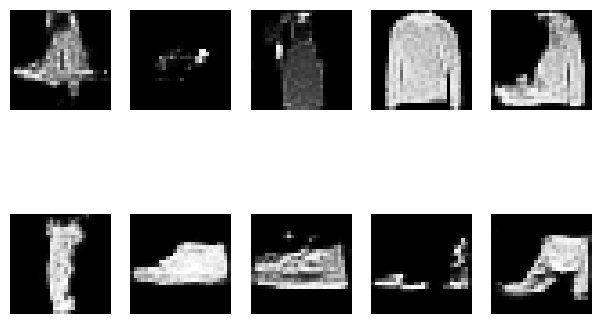

época -->  110


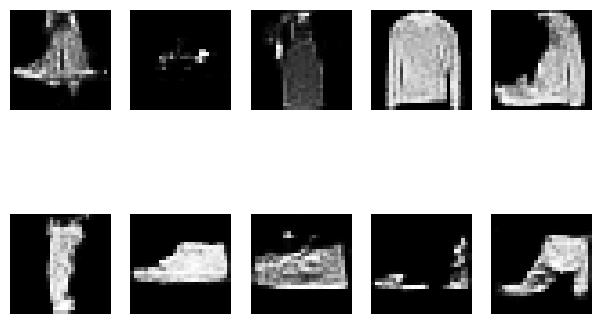

época -->  111


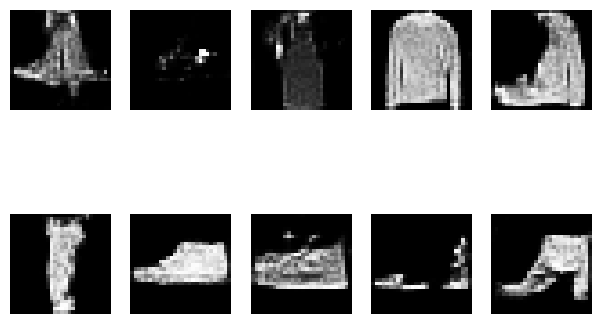

época -->  112


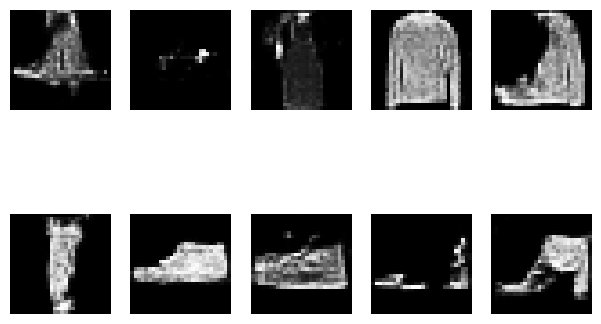

época -->  113


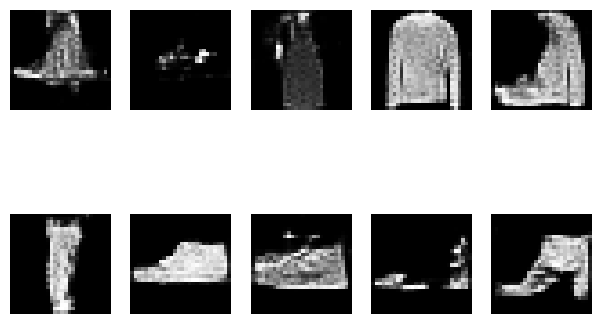

época -->  114


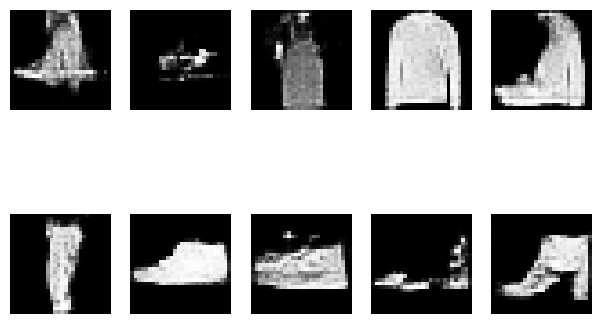

época -->  115


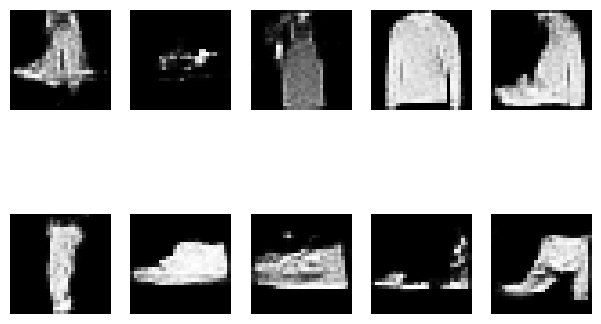

época -->  116


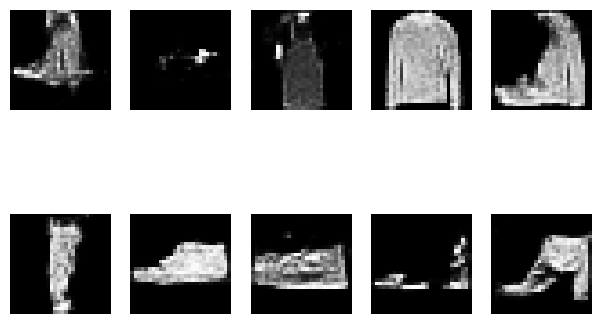

época -->  117


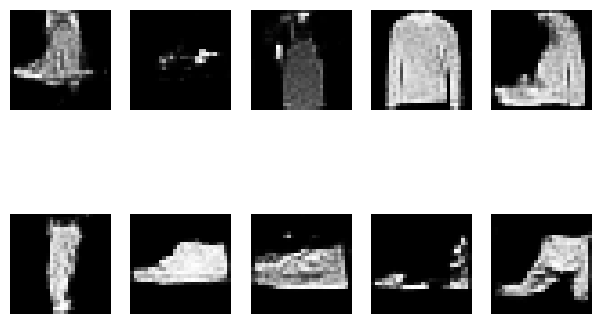

KeyboardInterrupt: 

In [32]:
#treinamento de fato

treina_gan(dataset, epochs, noises)

In [33]:
#pode salvar para continuar mais tarde o treinamento

meu_gerador.save_weights('/content/gerador.weights.h5')
meu_discriminador.save_weights('/content/discriminador.weights.h5')



In [ ]:
#basta instanciar novamente as redes neurais e carregar os pesos que havia treinado
# e recomeçar o treinamento
# ou mudar a etapa anterior de criação das instâncias para essas abaixo.
'''
meu_gerador.load_weights('gerador.h5')
meu_discriminador.load_weights('discriminador.h5')
'''